In [3]:
from transformers import pipeline


from FlagEmbedding import FlagReranker
import mailbox
from datetime import datetime
import pandas as pd
import re
import matplotlib.pyplot as plt

# Initialize for the language labeling

model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt)
#pipe(text, top_k=1, truncation=True)


# Initialize the formality analysis model
reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=True)

# Path to your mbox file
mbox_file_path = 'Sent.mbox'




# Open the mbox file

# Create DataFrame from extracted data


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--papluca--xlm-roberta-base-language-detection. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:

In [5]:
# Function to get the plain text content of an email message
def get_email_body(message):
    if message.is_multipart():
        parts = message.get_payload()
        for part in parts:
            if part.get_content_type() == 'text/plain':
                return part.get_payload(decode=True).decode(part.get_content_charset() or 'utf-8')
    else:
        return message.get_payload(decode=True).decode(message.get_content_charset() or 'utf-8')
    return ""

# Function to clean up the email body and remove quoted content

def determine_language(text):
    return pipe(text, top_k=1, truncation=True)[0]['label']


def is_reply(subject, body):
    # Check for "Re:" or "Fwd:" in the subject
    if subject and any(prefix in subject for prefix in ['Re:', 'Fwd:']):
        return True

    # Check for quoted text from previous emails
    if re.search(r'On .* wrote:', body) or '>' in body:
        return True

    return False


def clean_email_body(body):
    cleaned_body = re.sub(r'(?m)^>.*$', '', body)
    cleaned_body = re.split(r'\nOn .* wrote:\n', cleaned_body)[0]
    cleaned_body = re.sub(r'\r\n', ' ', cleaned_body)
    cleaned_body = re.sub(r'\s+', ' ', cleaned_body)
    return cleaned_body.strip()

# Function to compute formality score and classify
def get_formality_class(text):
    formal_score = reranker.compute_score(['Formal', text], normalize=True)[0]
    informal_score = reranker.compute_score(['Informal', text], normalize=True)[0]
    if formal_score >= informal_score :
        return ('Formal', (formal_score/informal_score))
    elif formal_score < informal_score:
        return ('Informal',(formal_score/informal_score))
    else:
        return 'Neutral'


In [6]:
mbox = mailbox.mbox(mbox_file_path)

# Extract data from each message
data = []
for i, message in enumerate(mbox):
    subject = message['subject']
    sender = message['from']
    date_str = message['date']
    body = get_email_body(message)

    if is_reply(subject, body):
        print(f"Skipping reply email: {subject}")
        continue


    date = None
    try:
        if date_str:
            date = datetime.strptime(date_str, '%a, %d %b %Y %H:%M:%S %z')
    except ValueError:
        print(f"Failed to parse date: {date_str}")

    cleaned_body = clean_email_body(body)

    # Get formality classification
    formality_class, formality_ratio = get_formality_class(cleaned_body)
    language = determine_language(cleaned_body)

    if date:
        data.append({
            'subject': subject,
            'sender': sender,
            'date': date,
            'body': cleaned_body,
            'formality': formality_class,
            'formality_ratio': formality_ratio,
            'language': language
        })
    else:
        print(f"Skipping email {i+1} due to date parsing issues.\n")


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 501.29it/s]
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:2888: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: Re: Hello from Uber Talent Acquisition!
Failed to parse date: Thu, 20 Jun 2024 11:09:44 -0400 (EDT)


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1013.12it/s]


Skipping email 3 due to date parsing issues.

Skipping reply email: AW: [EXT]Broken showerhead


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


Skipping reply email: Re: After Mobility Requirements
Skipping reply email: Re: After Mobility Requirements
Skipping reply email: Re: After Mobility Requirements


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: Re: DAK Gesundheit - your request
Skipping reply email: Fwd: DAK Gesundheit - your request
Skipping reply email: DAK Gesundheit - your request


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?RE=3A_ticket_with_ID=3A_SU0=2DAAAS=2D3206_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?RE=3A_ticket_with_ID=3A_SU0=2DAAAS=2D3206_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?Re=3A_ticket_with_ID=3A_SU0=2DAAAS=2D3206_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?RE=3A_ticket_with_ID=3A_SU0=2DAAAS=2D3206_hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 501.53it/s]


Skipping reply email: Re: Thank You for Completing Our GS Questionnaire!
Skipping reply email: Re: Thank You for Completing Our GS Questionnaire!
Skipping reply email: Thank You for Completing Our GS Questionnaire!
Skipping reply email: Re: Meeting
Skipping reply email: Re: Meeting
Skipping reply email: Re: Meeting
Skipping reply email: Re: Meeting
Skipping reply email: Re: Meeting
Skipping reply email: Re: Meeting


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: 


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: CS300_HW1
Skipping reply email: =?UTF-8?B?RndkOiBNYWtlIGEgc3BsYXNoIChhbmQgJDEwKSEg8J+Mig==?=
Skipping reply email: =?UTF-8?Q?Make_a_splash_(and_$10)!_=F0=9F=8C=8A?=
Skipping reply email: Re: PURE Fall Term Confirmation Reminder
Skipping reply email: PURE Fall Term Confirmation Reminder


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: RE: Bee Colony Optimization ve Akademik Kariyer Hk.


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.90it/s]


Skipping reply email: Re: Quiz ile ilgili


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?utf-8?B?UmU6IPCfkYAgc2lwYXJpxZ9pbiBiaXplIHVsYcWfdMSxIQ==?=
Skipping reply email: =?UTF-8?B?UmU6IPCfkYAgc2lwYXJpxZ9pbiBiaXplIHVsYcWfdMSxIQ==?=
Failed to parse date: Fri, 22 Dec 2023 17:44:52 +0000 (UTC)


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 330.34it/s]


Skipping email 49 due to date parsing issues.



pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: Re: Erasmus
Skipping reply email: Re: Erasmus
Skipping reply email: =?UTF-8?Q?Re=3A_Bitirme_Projesi_Hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 987.13it/s]


Skipping reply email: =?UTF-8?B?UmU6IEJpdGlybWUgdG9wbGFudMSxc8Sx?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Motivation letter help
Skipping reply email: Re: Motivation letter help
Skipping reply email: Re: Motivation letter help
Skipping reply email: Re: Motivation letter help
Skipping reply email: Re: Motivation letter help
Skipping reply email: Fwd: Motivation letter help


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.66it/s]


Skipping reply email: Re: CV help for Master's Application
Skipping reply email: Fwd: CV help for Master's Application


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Fwd:
Skipping reply email: Re: 
Skipping reply email: Re: 
Skipping reply email: Re: 
Skipping reply email: Re:
Skipping reply email: Re: 
Skipping reply email: Re: 
Skipping reply email: Re:


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Proj201_hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Fwd: Ihr Deutschlandticket April 2024


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Objection for the EP
Skipping reply email: Re: Objection for the EP


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: CS204 Final


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


Skipping reply email: =?UTF-8?B?UmU6IEhhZnRhbMSxayB0b3BsYW50xLEgLSBFTlMgNDkx?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


Skipping reply email: =?UTF-8?B?QUPEsEwvIMOWTkVNTMSwOiBEZXRheWzEsSBQdWFuIFTDvHLDvCDDllNZTSBTb251w6cgQg==?=
	=?UTF-8?B?ZWxnZXNpIEhrLg==?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Skipping reply email: Re: PURE


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: Re: GDSC - SUACM Mysu Duyurusu Hk.
Skipping reply email: Re: GDSC - SUACM Mysu Duyurusu Hk.
Skipping reply email: Re: GDSC - SUACM Mysu Duyurusu Hk.
Skipping reply email: Re: GDSC - SUACM Mysu Duyurusu Hk.
Skipping reply email: Re: GDSC - SUACM Mysu Duyurusu Hk.
Skipping reply email: Re: GDSC - SUACM Mysu Duyurusu Hk.
Skipping reply email: Re: GDSC - SUACM Mysu Duyurusu Hk.


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Yemeklerin_t=C3=BCkenmesi_hakkinda?=
Skipping reply email: =?UTF-8?Q?Re=3A_Yemeklerin_t=C3=BCkenmesi_hakkinda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.90it/s]


Skipping reply email: Fwd: Competition Launch: ISIC 2024 - Skin Cancer Detection with 3D-TBP


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 501.71it/s]


Skipping reply email: Re: Reminder: The Grant Payment Procedure& your missing documents
Skipping reply email: Reminder: The Grant Payment Procedure& your missing documents


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: About IF100 Final Exam Q6 Objection


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: =?UTF-8?B?UmU6IEJpdGlybWUgdG9wbGFudMSxc8Sx?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: Re: Internship Online Management System Approval Needed: Project
 Description Change
Skipping reply email: Re: Internship Online Management System Approval Needed: Project
 Description Change
Skipping reply email: =?UTF-8?Q?Re=3a_Yemekhane_hakk=c4=b1nda?=
Skipping reply email: =?UTF-8?Q?Re=3A_Yemekhane_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?Re=3A_Yemekhane_hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IMSwxZ4gQkFOS0FTSSBBTFRJTiBHRU7DhyAtIElOVEVSUkFJTCBCQcWeVlVSVVNV?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: Re: Evrak teslimi


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: Re: bunq - offer
Skipping reply email: Re: bunq - offer
Skipping reply email: Re: bunq - offer


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: Re: Antrag Ersatzkarte - Verlust CampusCard


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: AW: Your Application - University of Passau
Skipping reply email: Re: Your Application - University of Passau


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Skipping reply email: 
 =?windows-1254?Q?Re:_Arda_Ayd=FDn_|_Sales_Operations_WINtern,_L'Or=E9al_L?=
 =?windows-1254?Q?uxe?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]


Skipping reply email: Re: IE311 Quiz
Skipping reply email: Re: IE311 Quiz
Skipping reply email: Fwd: IE311 Quiz


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IE9EQSBBUktBREHFnkkgSEss?=
Skipping reply email: =?UTF-8?Q?ODA_ARKADA=c5=9eI_HK=2c?=
Skipping reply email: RE: Case Study 2 Hk.


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


Skipping reply email: Re: IE 311
Skipping reply email: Re: IE 311
Skipping reply email: Re: IE 311


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: Re:


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


Skipping reply email: =?UTF-8?Q?Re=3a_Yemek_miktarlar=c4=b1_hakk=c4=b1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: =?UTF-8?B?UmU6IEthaHZhbHTEsSBmaXlhdGxhcsSx?=
Skipping reply email: =?UTF-8?B?UmU6IEthaHZhbHTEsSBmaXlhdGxhcsSx?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Skipping reply email: =?UTF-8?B?UmU6IEFyZGEgQXlkxLFuIC0gQWthZGVtaWsgRGFuxLHFn2Fu?=
Skipping reply email: =?UTF-8?B?UmU6IEFyZGEgQXlkxLFuIC0gQWthZGVtaWsgRGFuxLHFn2Fu?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: =?UTF-8?Q?Re=3a_Depozito_=c4=b0adeleri_i=c3=a7in_IBAN_No_/_IBAN_num?=
 =?UTF-8?Q?ber_for_Deposit_Refunds?=
Skipping reply email: =?UTF-8?Q?Re=3a_Depozito_=c4=b0adeleri_i=c3=a7in_IBAN_No_/_IBAN_num?=
 =?UTF-8?Q?ber_for_Deposit_Refunds?=
Skipping reply email: =?UTF-8?Q?Re=3A_Depozito_=C4=B0adeleri_i=C3=A7in_IBAN_No_=2F_IBAN_number_f?=
	=?UTF-8?Q?or_Deposit_Refunds?=
Skipping reply email: =?UTF-8?Q?Depozito_=c4=b0adeleri_i=c3=a7in_IBAN_No_/_IBAN_number_fo?=
 =?UTF-8?Q?r_Deposit_Refunds?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: WSP3 section K
Skipping reply email: Re: WSP3 section K
Skipping reply email: Re: WSP3 section K
Skipping reply email: Re: WSP3 section K


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: Re: Problem regarding scheduling Get Shit Done day
Skipping reply email: Problem regarding scheduling Get Shit Done day


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IEXEn2l0bWVuIG1haWwgdGFzbGHEn8Sx?=
Skipping reply email: =?UTF-8?B?UmU6IEXEn2l0bWVuIG1haWwgdGFzbGHEn8Sx?=
Skipping reply email: =?UTF-8?B?UmU6IEXEn2l0bWVuIG1haWwgdGFzbGHEn8Sx?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: Re: FIN499 Grup Odevi Hakkinda


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: PURE hk.
Skipping reply email: Re: PURE hk.
Skipping reply email: Re: PURE hk.
Skipping reply email: Re: PURE hk.
Skipping reply email: Re: PURE hk.
Skipping reply email: Re: PURE hk.
Skipping reply email: Re: PURE hk.
Skipping reply email: Re: PURE hk.


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IEFDxLBMIELEsExHxLAuLi4=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: Re: 


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Erasmus_dersleri_not_giri=C5=9Fi_hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]


Skipping reply email: Re: IE 311 - LA
Skipping reply email: Re: IE 311 - LA
Skipping reply email: Re: IE 311 - LA
Skipping reply email: IE 311 - LA


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 919.00it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Arda_Ayd=C4=B1n_ek_belge?=
Failed to parse date: Fri, 09 Feb 2024 02:45:52 -0800 (PST)


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping email 252 due to date parsing issues.



pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Dogum=5Fguncuku=2Ecpp_hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]


Skipping reply email: Re: IE 311 recitation production planning kodu


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


Skipping reply email: Re: Math 203 final grades objection
Skipping reply email: Re: Math 203 final grades objection
Skipping reply email: Re: Math 203 final grades objection


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


Skipping reply email: Re: Your Application to P.I. Works


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1004.38it/s]


Skipping reply email: =?UTF-8?B?UmU6IEfDtnLDvMWfbWUgdGFsZWJp?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]


Skipping reply email: Re: Duyuru talebi
Skipping reply email: Re: Duyuru talebi
Skipping reply email: Re: Duyuru talebi


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Writing task 1 feedback


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: Re: Recit 6 Q1
Skipping reply email: Recit 6 Q1
Skipping reply email: Re: data
Skipping reply email: Re: data
Skipping reply email: data


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Yurt_Ba=C5=9Fvurusu_Hakk=2E?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.18it/s]


Skipping reply email: =?UTF-8?Q?Re=3a_Antijen_Testi_=c3=96rnek_Al=c4=b1m=c4=b1-15_Ekim/An?=
 =?UTF-8?Q?tigen_Test_Sample_Collection-15_October?=
Skipping reply email: =?UTF-8?Q?Re=3A_Antijen_Testi_=C3=96rnek_Al=C4=B1m=C4=B1=2D15_Ekim=2FAntigen_Tes?=
	=?UTF-8?Q?t_Sample_Collection=2D15_October?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 334.29it/s]


Skipping reply email: Re: bunq | your Get Shit Done day


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: RE: ticket with ID: SU0-AAAS-3206


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1004.38it/s]


Skipping reply email: Re: W&S Writing task 2 feedback


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Adobe Scan 09 Eki 2023.pdf


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus
Skipping reply email: Re: IE 311 Syllabus


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3a_Yemekhanede_yemek_bitmesi_hakk=c4=b1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.90it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Burs_hakk=C4=B1nda_bilgi?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: IE 395 raporu (revizyon)
Skipping reply email: Re: IE 395 raporu (revizyon)


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Proj 201
Skipping reply email: Re: Proj 201
Skipping reply email: Re: Proj 201
Skipping reply email: Re: Proj 201


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_=5B202201PROJ201=2DDoruk_G=C3=BCnayd=C4=B1n=27_s_Projects=5D_Pro?=
	=?UTF-8?Q?j_201_First_Meeting?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Tutorial for EP
Skipping reply email: Re: Tutorial for EP
Skipping reply email: Re: Tutorial for EP
Skipping reply email: Re: Tutorial for EP


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IDIuIHlhesSxIMO2ZGV2aSBpbGUgaWxnaWxp?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.66it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Soru_Excel=27i_ile_alakal=C4=B1?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Solution Challenge Duyuru


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 501.41it/s]


Skipping reply email: Re: Gamified Assessment


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: =?UTF-8?Q?Fwd=3A_Deutsche_Bank_Quantitative_Internship_Programme?=
	=?UTF-8?Q?_=E2=80=93_Technical_Test?=
Failed to parse date: Tue, 05 Dec 2023 17:40:35 +0000 (UTC)


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping email 367 due to date parsing issues.



pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: Re: About the question you asked


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Yan_dal_ba=C5=9Fvuru_durumu?=
Skipping reply email: =?UTF-8?Q?Re=3A_Yan_dal_ba=C5=9Fvuru_durumu?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_=5BFirebase=5D_Eyl=C3=BCl_=C3=96yk=C3=BC_=C5=9Een_=28Student=29_added_yo?=
	=?UTF-8?Q?u_as_a_collaborator_on_the_project_=27cs306=27?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: =?UTF-8?Q?Re=3a_Ak=c5=9fam_yeme=c4=9finde_tabldotun_bitmesine_dair?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


Skipping reply email: =?UTF-8?Q?Sabanc=C4=B1_=C3=9Cniversitesi_GDSC_E=C4=9Fitim_Daveti?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IEJpdGlybWUgdG9wbGFudMSxc8Sx?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


Skipping reply email: Re: Next Steps in Your Application for the Global Markets Internship
 Programme (London) 2025 role!
Skipping reply email: Re: Next Steps in Your Application for the Global Markets Internship
 Programme (London) 2025 role!
Skipping reply email: Next Steps in Your Application for the Global Markets Internship
 Programme (London) 2025 role!


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Proje_hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 501.35it/s]


Skipping reply email: =?UTF-8?B?UmU6IEhpYmUgc8O2emxlxZ9tZXNp?=
Skipping reply email: =?UTF-8?B?UmU6IEhpYmUgc8O2emxlxZ9tZXNp?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Final objection


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?Re=3a_Erasmus_ba=c5=9fvurusu_hakk=c4=b1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: Re: ECON 202 Grubu


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IEJpdGlybWUgdG9wbGFudMSxc8Sx?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1004.62it/s]


Skipping reply email: Re:


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_GSD_day_hakk=C4=B1nda=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_GSD_day_hakk=C4=B1nda=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_GSD_day_hakk=C4=B1nda=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_GSD_day_hakk=C4=B1nda=2E?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_=C3=B6nemli=5Flearning_agreement_belgen_hk?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: AW: Rental Contract


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: PURE Hakk.
Skipping reply email: Re: PURE Hakk.
Skipping reply email: Re: PURE Hakk.


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?B?UmU6IExlZXh0IC0gU2FiYW5jxLEgR0RTQyBpxZ9iaXJsacSfaSBoYWtrxLFuZGE=?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?B?UmU6IFllbmkgdG9wbGFudMSxIGfDvG4tc2FhdGk=?=
Skipping reply email: =?UTF-8?Q?Yeni_toplant=C4=B1_g=C3=BCn=2Dsaati?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Learning_Agreement_ve_ders_se=C3=A7imi_hakk=C4=B1nd?=
 =?UTF-8?Q?a?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


Skipping reply email: AW: Meldung 10 and money transfer for enrollment


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.66it/s]


Skipping reply email: Re: about the exam
Skipping reply email: Re: about the exam


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Fwd: Rental contract for your dorm room


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Accomadation in Passau
Skipping reply email: AW: Accomadation in Passau
Skipping reply email: AW: Accomadation in Passau
Skipping reply email: Re: Accomadation in Passau
Skipping reply email: Re: Accomadation in Passau
Skipping reply email: Re: Accomadation in Passau


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?iso-8859-9?Q?Ders_Kay=FDd=FD_Hk.?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: Re: Tomorrow's Class for Section A is postponed


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]


Skipping reply email: Re: Akbank_Dekont


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


Skipping reply email: =?UTF-8?B?UmU6IG9kYSBkZcSfacWfaW1p?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: IE 311 - LA listesi
Skipping reply email: Re: IE 311 - LA listesi
Skipping reply email: Re: IE 311 - LA listesi
Skipping reply email: IE 311 - LA listesi


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IEHFn8SxIEthcnTEsQ==?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: Re: 


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Mezuniyet_Planlaman=C4=B1z_hk?=
Skipping reply email: =?UTF-8?Q?Mezuniyet_Planlaman=C4=B1z_hk?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Skipping reply email: Re: Hot off the griddle!
Skipping reply email: Fwd: Hot off the griddle!
Skipping reply email: Hot off the griddle!


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Master_Ba=C5=9Fvuruma_dair?=
Skipping reply email: =?UTF-8?Q?Re=3A_Master_Ba=C5=9Fvuruma_dair?=
Skipping reply email: =?UTF-8?Q?Re=3A_Master_Ba=C5=9Fvuruma_dair?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 501.23it/s]


Skipping reply email: Re: Quiz 1 - Hata
Skipping reply email: Re: Quiz 1 - Hata


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: Re: Quiz 2
Skipping reply email: Re: Quiz 2


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_HIST_191_2=2E_Grup_Final_S=C4=B1nav=C4=B1?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: Fwd: 


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: Re: PURE Spring Term Student List
Skipping reply email: Re: PURE Spring Term Student List
Skipping reply email: Re: PURE Spring Term Student List
Skipping reply email: Re: PURE Spring Term Student List
Skipping reply email: Re: PURE Spring Term Student List
Skipping reply email: Re: PURE Spring Term Student List
Skipping reply email: Re: PURE Spring Term Student List
Skipping reply email: Fwd: PURE Spring Term Student List


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: OA2 Stand-by student
Skipping reply email: Re: OA2 Stand-by student
Skipping reply email: OA2 Stand-by student


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IFByb2plIGRhbsSxxZ9tYW5sxLFrIHRhbGViaSBoYWtrxLFuZGE=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: Re: bunq | your Get Shit Done day assignment


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1000.79it/s]


Skipping reply email: =?UTF-8?B?UmU6IERlcnMgc2XDp2ltaSBoYWtrxLFuZGE=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Pure_Projesi_Hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?Re=3A_Pure_Projesi_Hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Fwd: NatWest Group (Workday) Assessment feedback report(s)


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


Skipping reply email: =?UTF-8?B?UmU6IEfDtnLDvMWfbWUgVGFsZWJp?=
Skipping reply email: =?UTF-8?B?UmU6IEfDtnLDvMWfbWUgVGFsZWJp?=
Skipping reply email: =?UTF-8?B?UmU6IEfDtnLDvMWfbWUgVGFsZWJp?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?B?UmU6IEJpdGlybWUgVG9wbGFudMSxc8Sx?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.18it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_YURT_KAYDI_=C4=B0=C3=87=C4=B0N_GEREKL=C4=B0_EVRAKLAR_=2D_DOCUMENTS?=
	=?UTF-8?Q?_NEEDED_FOR_DORMITORY_REGISTRATION?=
Skipping reply email: =?UTF-8?B?WVVSVCBLQVlESSDEsMOHxLBOIEdFUkVLTMSwIEVWUkFLTEFSIC0gRE9D?=
 =?UTF-8?Q?UMENTS_NEEDED_FOR_DORMITORY_REGISTRATION?=
Skipping reply email: =?UTF-8?B?UmU6IFlhcsSxbiAxNi4zMC0xOC4zMCByZWNpdGF0aW9uJ8SxIGhha2vEsW5kYQ==?=
Skipping reply email: =?UTF-8?B?UmU6IFlhcsSxbiAxNi4zMC0xOC4zMCByZWNpdGF0aW9uJ8SxIGhha2vEsW5kYQ==?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Re[2]: B1 QUIZ
Skipping reply email: =?UTF-8?B?UmVbMl06IEIxIFFVSVo=?=
Skipping reply email: Re: B1 QUIZ
Skipping reply email: Re: B1 QUIZ
Skipping reply email: Re: B1 QUIZ


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1040.77it/s]


Skipping reply email: Re: PURE


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: IE 312 LA olmak ister misiniz?
Skipping reply email: Re: IE 312 LA olmak ister misiniz?
Skipping reply email: IE 312 LA olmak ister misiniz?


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.27it/s]


Skipping reply email: Re: Presentation about Quality Education


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Case1-Q4


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: ID
Skipping reply email: Re: ID


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1004.14it/s]


Skipping reply email: =?UTF-8?B?UmU6IEJhxZ92dXJ1IHZlIGRlxJ9lcmxlbmRpcm1lIHPDvHJlY2kgaGFra8SxbmRh?=
Skipping reply email: 
 =?utf-8?B?UkU6IEJhxZ92dXJ1IHZlIGRlxJ9lcmxlbmRpcm1lIHPDvHJlY2kgaGFra8Sx?=
 =?utf-8?Q?nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]


Skipping reply email: Re: PURE & ENS491 - MATCHING: Exercises
Skipping reply email: Re: PURE & ENS491 - MATCHING: Exercises
Skipping reply email: Re: PURE & ENS491 - MATCHING: Exercises
Skipping reply email: Re: PURE & ENS491 - MATCHING: Exercises
Skipping reply email: Re: PURE & ENS491 - MATCHING: Exercises
Skipping reply email: Re: PURE & ENS491 - MATCHING: Exercises
Skipping reply email: Re: PURE & ENS491 - MATCHING: Exercises
Skipping reply email: Re: PURE & ENS491 - MATCHING: Exercises


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


Skipping reply email: =?UTF-8?Q?RE=3A_Maj=C3=B6r_deklerasyonu?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Proj201


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Participation_Notland=C4=B1rmas=C4=B1_Hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


Skipping reply email: Re: Compose camp workshop
Skipping reply email: Re: Compose camp workshop
Skipping reply email: Re: Compose camp workshop


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: Re: Third Individual Assesment
Skipping reply email: Re: Third Individual Assesment


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: AW: Exchange Student Documents


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IEhJU1QgMTkyIEZpbmFsIFPEsW5hdsSxLTIuIGdydXA=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.18it/s]


Skipping reply email: Fwd: Accommodation in Passau
Skipping reply email: AW: Accommodation in Passau
Skipping reply email: Re: Accommodation in Passau
Skipping reply email: Accommodation in Passau 
Skipping reply email: Re: midterm 1 grade
Skipping reply email: midterm 1 grade
Skipping reply email: =?UTF-8?Q?Re=3A_Proj201_gruplar=C4=B1?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]


Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping reply email: Re: Proj 201 Group 2
Skipping re

pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?iso-8859-3?Q?Re:_Tabldot_men=FC?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: Re: DAK Gesundheit: Your inquiry
Skipping reply email: DAK Gesundheit: Your inquiry
Skipping reply email: Re: Koltuk
Skipping reply email: Re: Koltuk


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?Fwd=3A_Vize_i=C3=A7in_gerekli_evraklar?=
Skipping reply email: =?UTF-8?Q?Fwd=3A_Vize_i=C3=A7in_gerekli_evraklar?=
Skipping reply email: =?UTF-8?Q?Re=3A_Vize_i=C3=A7in_gerekli_evraklar?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Vize_i=C3=A7in_gerekli_evraklar?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Vize_i=C3=A7in_gerekli_evraklar?=
Skipping reply email: =?UTF-8?Q?Re=3A_Vize_i=C3=A7in_gerekli_evraklar?=
Skipping reply email: =?UTF-8?Q?Re=3A_Vize_i=C3=A7in_gerekli_evraklar?=
Skipping reply email: =?UTF-8?Q?Re=3A_Vize_i=C3=A7in_gerekli_evraklar?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: Re: Erasmus Hibe
Skipping reply email: Re: Erasmus Hibe


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: Re: Bitirme projesi


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: Fwd: Looking to grab a Prime Day deal?
Skipping reply email: Re: Looking to grab a Prime Day deal?
Skipping reply email: Looking to grab a Prime Day deal?
Skipping reply email: =?UTF-8?Q?Re=3A_Bitirme_projesi_toplant=C4=B1s=C4=B1?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Failed to parse date: Tue, 01 Mar 2022 08:15:51 -0800 (PST)


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


Skipping email 789 due to date parsing issues.

Skipping reply email: Re: ENS208-AB-202102: Tomorrow's Class for Section A is postponed
Skipping reply email: ENS208-AB-202102: Tomorrow's Class for Section A is postponed


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Request for an interview
Skipping reply email: Re: Request for an interview
Skipping reply email: Re: Request for an interview
Skipping reply email: Re: Request for an interview
Skipping reply email: Re: Request for an interview


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?B?UmU6IEJ1IGhhZnRhIFNhbMSxIGfDvG7DvCBrYXTEsWxtYW1hbSBoYWtrxLFuZGE=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Skipping reply email: =?UTF-8?Q?Re:_Arda,_Bloke_Hesap_onay=C4=B1n=C4=B1z?=
Skipping reply email: =?UTF-8?B?UmU6IEFyZGEsIEJsb2tlIEhlc2FwIG9uYXnEsW7EsXo=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.42it/s]


Skipping reply email: =?UTF-8?B?RndkOiBVbmlsZXZlciBJZGVhVHJvcGh5IEJhxZ92dXJ1bGFyxLEgQmHFn2xhZMSxISA=?=
	=?UTF-8?B?8J+aqCBIYWRpIEhlbWVuIFNlbiBkZSBZZXJpbmkgQWwhIPCfmIk=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Skipping reply email: Re: McGraw Hill Scholarship


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: RE: Anadal deklerasyonu


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: Re: Tabldot
Skipping reply email: Re: Tabldot
Skipping reply email: Re: Tabldot
Skipping reply email: Re: Tabldot
Skipping reply email: Re: Tabldot
Skipping reply email: Re: Tabldot
Skipping reply email: Re: Tabldot


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_GDSC_E=C4=9Fitim_Daveti?=
Skipping reply email: =?UTF-8?Q?Re=3A_GDSC_E=C4=9Fitim_Daveti?=
Skipping reply email: =?UTF-8?Q?GDSC_E=C4=9Fitim_Daveti?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Bu_haftaki_bitirme_toplant=C4=B1s=C4=B1?=
Skipping reply email: =?UTF-8?Q?Re=3A_Bu_haftaki_bitirme_toplant=C4=B1s=C4=B1?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Exciting Internship Opportunity at TD Securities Just for You!
Skipping reply email: Exciting Internship Opportunity at TD Securities Just for You!


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?RndkOiBTR0sgxLDFn2UgR2lyacWfIEJpbGRpcmdlc2k=?=
Skipping reply email: =?UTF-8?B?UmU6IFNHSyDEsMWfZSBHaXJpxZ8gQmlsZGlyZ2VzaQ==?=
Skipping reply email: =?UTF-8?B?UmU6IFNHSyDEsMWfZSBHaXJpxZ8gQmlsZGlyZ2VzaQ==?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_haftal=C4=B1k_toplant=C4=B1_saati?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_haftal=C4=B1k_toplant=C4=B1_saati?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: rewrited version of summary


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3a_B=c3=b6l=c3=bcm_deklare_etmeden_Erasmus_ba=c5=9fvur?=
 =?UTF-8?Q?usu_yapmak_hakk=c4=b1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: P&G - please reply
Failed to parse date: Thu,  3 Nov 2022 10:00:40 +0000 (UTC)


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping email 873 due to date parsing issues.



pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Proj 201 grup 2
Skipping reply email: Re: Proj 201 grup 2
Skipping reply email: Re: Proj 201 grup 2


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Master_ba=C5=9Fvurusu_hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.18it/s]


Skipping reply email: =?UTF-8?B?UmU6IEhhZnRhbMSxayB0b3BsYW50xLE=?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Sabanc=C4=B1_=C3=9Cniversitesi_GDSC_E=C4=9Fitim_Daveti?=
Skipping reply email: =?UTF-8?Q?Re=3A_Sabanc=C4=B1_=C3=9Cniversitesi_GDSC_E=C4=9Fitim_Daveti?=
Skipping reply email: =?UTF-8?Q?Re=3A_Sabanc=C4=B1_=C3=9Cniversitesi_GDSC_E=C4=9Fitim_Daveti?=
Skipping reply email: =?UTF-8?Q?Re=3A_Sabanc=C4=B1_=C3=9Cniversitesi_GDSC_E=C4=9Fitim_Daveti?=
Skipping reply email: =?UTF-8?Q?Sabanc=C4=B1_=C3=9Cniversitesi_GDSC_E=C4=9Fitim_Daveti?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_=C3=96NEML=C4=B0_=3A_Form_ve_Evrak_y=C3=BCkleme_=2F_IMPORTANT_=3A_?=
	=?UTF-8?Q?Uploading_Forms_and_Documents?=
Skipping reply email: =?UTF-8?Q?=c3=96NEML=c4=b0_=3a_Form_ve_Evrak_y=c3=bckleme_/_IMPORTA?=
 =?UTF-8?Q?NT_=3a_Uploading_Forms_and_Documents?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Erasmus_Transkript=2DArda_Ayd=C4=B1n?=
Skipping reply email: =?UTF-8?Q?Re=3A_Erasmus_Transkript-Arda_Ayd=C4=B1n?=
Skipping reply email: =?UTF-8?Q?Re:_Erasmus_Transkript-Arda_Ayd=C4=B1n?=
Skipping reply email: =?UTF-8?Q?Re=3A_Erasmus_Transkript=2DArda_Ayd=C4=B1n?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 997.69it/s]


Skipping reply email: Re: Review anything in here for $10
Skipping reply email: Review anything in here for $10
Skipping reply email: Re: process essay
Skipping reply email: Re: process essay


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: =?UTF-8?B?UmU6IEhpc3QgMTkxLUEgU8SxbmF2xLE=?=
Skipping reply email: =?UTF-8?B?UmU6IEhpc3QgMTkxLUEgU8SxbmF2xLE=?=
Skipping reply email: =?UTF-8?B?UmU6IEhpc3QgMTkxLUEgU8SxbmF2xLE=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: AW: Enrolment Documents


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.18it/s]


Skipping reply email: Re: IE311 Office Hour


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Portf=C3=B6y_optimizasyonu_hk=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_Portf=C3=B6y_optimizasyonu_hk=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_Portf=C3=B6y_optimizasyonu_hk=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_Portf=C3=B6y_optimizasyonu_hk=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_Portf=C3=B6y_optimizasyonu_hk=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_Portf=C3=B6y_optimizasyonu_hk=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_Portf=C3=B6y_optimizasyonu_hk=2E?=
Skipping reply email: =?UTF-8?Q?Re=3A_Portf=C3=B6y_optimizasyonu_hk=2E?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Hit Song Prediction Project Proposal
Skipping reply email: Re: Hit Song Prediction Project Proposal
Skipping reply email: Re: Hit Song Prediction Project Proposal
Skipping reply email: Re: Hit Song Prediction Project Proposal
Skipping reply email: Re: Hit Song Prediction Project Proposal
Skipping reply email: Re: Hit Song Prediction Project Proposal
Skipping reply email: Re: Hit Song Prediction Project Proposal


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Yemek_porsiyonlar=C4=B1_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?Re=3a_Yemek_porsiyonlar=c4=b1_hakk=c4=b1nda?=
Skipping reply email: =?UTF-8?Q?Re=3A_Yemek_porsiyonlar=C4=B1_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?Re=3a_Yemek_porsiyonlar=c4=b1_hakk=c4=b1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: feedback


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IDI4LjA0IEN1bWEgVG9wbGFudMSxc8SxIEhha2vEsW5kYQ==?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


Skipping reply email: Re: Erasmus'ta iken ENS 492
Skipping reply email: Re: Erasmus'ta iken ENS 492
Skipping reply email: Re: Erasmus'ta iken ENS 492
Skipping reply email: Re: Erasmus'ta iken ENS 492
Skipping reply email: Re: Erasmus'ta iken ENS 492
Skipping reply email: Re: Erasmus'ta iken ENS 492
Skipping reply email: Re: Erasmus'ta iken ENS 492
Skipping reply email: Re: Erasmus'ta iken ENS 492
Skipping reply email: Re: Erasmus'ta iken ENS 492


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


Skipping reply email: Re: GDSC
Skipping reply email: Fwd: GDSC


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IFlheiBzdGFqxLEgYmHFn3Z1cnU=?=
Skipping reply email: =?UTF-8?B?UmU6IFlheiBzdGFqxLEgYmHFn3Z1cnU=?=
Skipping reply email: =?UTF-8?B?UmU6IFlheiBzdGFqxLEgYmHFn3Z1cnU=?=
Skipping reply email: =?UTF-8?B?UmU6IFlheiBzdGFqxLEgYmHFn3Z1cnU=?=
Skipping reply email: =?UTF-8?B?RndkOiBZYXogc3RhasSxIGJhxZ92dXJ1?=
Skipping reply email: =?UTF-8?B?UmU6IFlheiBzdGFqxLEgYmHFn3Z1cnU=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.94it/s]


Skipping reply email: =?UTF-8?B?UmU6IFlheiBzdGFqxLEgYmHFn3Z1cnU=?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IFlheiBzdGFqxLEgYmHFn3Z1cnU=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Skipping reply email: 


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Quiz 3
Skipping reply email: Fwd: Quiz 3


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: IE303 Final objection


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.46it/s]


Skipping reply email: Re: Yurt
Skipping reply email: Re: Yurt


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Fwd: EarlyBird Venture Capital Internship & Job Opportunities
Skipping reply email: EarlyBird Venture Capital Internship & Job Opportunities
Skipping reply email: Re: Cs306 grade onjection


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.98it/s]


Skipping reply email: Fwd: Math306 notlar


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


Skipping reply email: Re: Distinguished Research Fellows Seminerleri
Skipping reply email: Fwd: Distinguished Research Fellows Seminerleri
Skipping reply email: AW: [EXT]Clogged Sink and Bathtub
Skipping reply email: AW: [EXT]Clogged Sink and Bathtub


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.66it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_Staj_dersi_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?Re=3A_Staj_dersi_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?Re=3A_Staj_dersi_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?Re=3A_Staj_dersi_hakk=C4=B1nda?=
Skipping reply email: =?UTF-8?Q?Re=3A_Staj_dersi_hakk=C4=B1nda?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Sabah saatlerindeki shuttlelar


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?B?UmU6IEfDvHJzZWwgaWxlIGFsYWthbMSxIMWfaWtheWV0?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3A_E_devlet_=C3=B6=C4=9Frenci_belgesi_sorgulama?=


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: Re: Tll 102 sunum


pre tokenize: 100%|██████████| 1/1 [00:00<?, ?it/s]


Skipping reply email: =?UTF-8?Q?Re=3a_Erasmus_yerle=c5=9ftirmesine_itiraz?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1002.70it/s]


Skipping reply email: =?UTF-8?B?R0RTQy1UZW5zb3JmbG93IDEuIGvEsXPEsW0=?=


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


Skipping reply email: Re: ie311 quiz answer key
Skipping reply email: Re: ie311 quiz answer key
Skipping reply email: Re: ie311 quiz answer key
Skipping reply email: Fwd: ie311 quiz answer key


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


Skipping reply email: Re: Data kismi
Skipping reply email: Re: Data kismi
Skipping reply email: Re: Data kismi
Skipping reply email: Re: Data kismi


pre tokenize: 100%|██████████| 1/1 [00:00<00:00, 1003.90it/s]


Formality Distribution:
formality
Formal      502
Informal      9
Name: count, dtype: int64


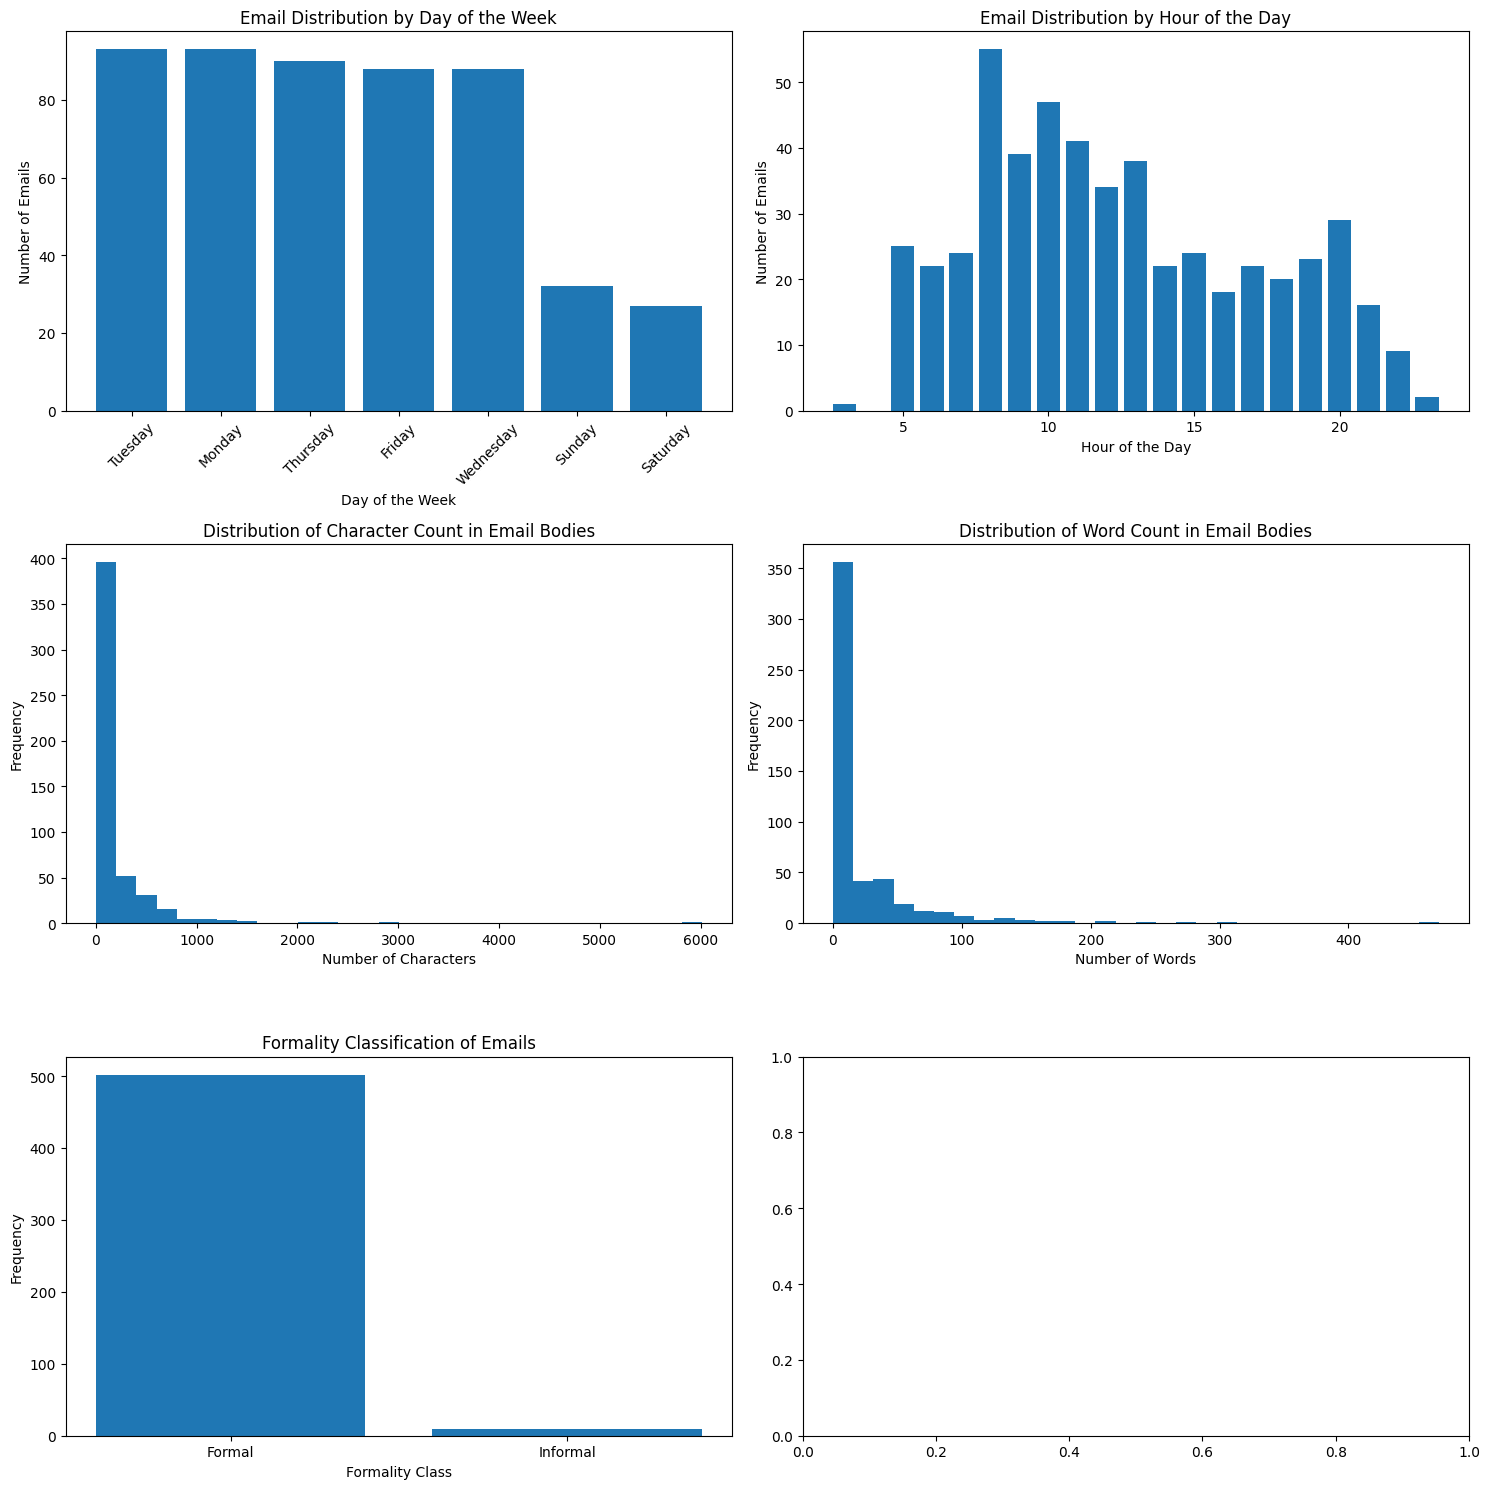

In [7]:
df = pd.DataFrame(data)

# Ensure 'date' exists and is converted to UTC
if 'date' in df.columns and not df['date'].isnull().all():
    df['date'] = pd.to_datetime(df['date'], utc=True)
    df['day_of_week'] = df['date'].dt.day_name()
    df['hour'] = df['date'].dt.hour
    df['body_length'] = df['body'].apply(len)
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))

    # Formally classification summary
    formality_counts = df['formality'].value_counts()
    print(f"Formality Distribution:\n{formality_counts}")

    # Plotting formality distribution
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))

    # Day of the week distribution
    day_distribution = df['day_of_week'].value_counts()
    axs[0, 0].bar(day_distribution.index, day_distribution.values)
    axs[0, 0].set_xlabel('Day of the Week')
    axs[0, 0].set_ylabel('Number of Emails')
    axs[0, 0].set_title('Email Distribution by Day of the Week')
    axs[0, 0].tick_params(axis='x', rotation=45)

    # Hour of the day distribution
    hour_distribution = df['hour'].value_counts().sort_index()
    axs[0, 1].bar(hour_distribution.index, hour_distribution.values)
    axs[0, 1].set_xlabel('Hour of the Day')
    axs[0, 1].set_ylabel('Number of Emails')
    axs[0, 1].set_title('Email Distribution by Hour of the Day')

    # Character count distribution
    axs[1, 0].hist(df['body_length'], bins=30)
    axs[1, 0].set_xlabel('Number of Characters')
    axs[1, 0].set_ylabel('Frequency')
    axs[1, 0].set_title('Distribution of Character Count in Email Bodies')

    # Word count distribution
    axs[1, 1].hist(df['word_count'], bins=30)
    axs[1, 1].set_xlabel('Number of Words')
    axs[1, 1].set_ylabel('Frequency')
    axs[1, 1].set_title('Distribution of Word Count in Email Bodies')

    # Formality distribution
    axs[2, 0].bar(formality_counts.index, formality_counts.values)
    axs[2, 0].set_xlabel('Formality Class')
    axs[2, 0].set_ylabel('Frequency')
    axs[2, 0].set_title('Formality Classification of Emails')



    plt.tight_layout()
    plt.show()

else:
    print("The 'date' column was not found in the DataFrame or all date values are missing.")


In [12]:
df.to_json('Not_Reply.json', orient='records', date_format='iso')
